In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 读 Kaggle 格式的 Tweet Sentiment Extraction 数据
train_df = pd.read_csv("train.csv")
print(train_df.head())

TEXT_COL = "text"
SEL_COL = "selected_text"
SENT_COL = "sentiment"

train_df = train_df.dropna(subset=[TEXT_COL, SEL_COL, SENT_COL]).reset_index(drop=True)
print("After drop NA:", train_df.shape)


Device: cuda
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  
After drop NA: (27480, 4)


In [18]:
def simple_tokenize(text):
    # 简单按空格切，baseline 不用太复杂
    return text.strip().split()

def find_span_token_indices(text, selected_text):
    """
    把字符级的 selected_text 映射到 word token 起止 index。
    如果对齐失败，就退化为整句。
    """
    text_lower = text.lower()
    sel_lower = selected_text.lower().strip()
    start_char = text_lower.find(sel_lower)
    if start_char == -1:
        tokens = simple_tokenize(text)
        return tokens, 0, len(tokens) - 1

    end_char = start_char + len(sel_lower) - 1
    tokens = simple_tokenize(text)
    char_idx = 0
    token_start_idx, token_end_idx = 0, len(tokens) - 1

    token_char_spans = []
    for tok in tokens:
        while char_idx < len(text) and text[char_idx] == " ":
            char_idx += 1
        tok_start = char_idx
        tok_end = tok_start + len(tok) - 1
        token_char_spans.append((tok_start, tok_end))
        char_idx = tok_end + 1

    for i, (s, e) in enumerate(token_char_spans):
        if s <= start_char <= e:
            token_start_idx = i
            break
    for j in range(len(token_char_spans)-1, -1, -1):
        s, e = token_char_spans[j]
        if s <= end_char <= e:
            token_end_idx = j
            break

    if token_start_idx > token_end_idx:
        token_start_idx, token_end_idx = 0, len(tokens)-1

    return tokens, token_start_idx, token_end_idx

# 简单测试一下对齐是否正常
row = train_df.iloc[0]
tokens, s_idx, e_idx = find_span_token_indices(row[TEXT_COL], row[SEL_COL])
print(row[TEXT_COL])
print(tokens)
print("span:", s_idx, e_idx, "->", " ".join(tokens[s_idx:e_idx+1]))


 I`d have responded, if I were going
['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going']
span: 0 6 -> I`d have responded, if I were going


In [19]:
all_sentences = train_df[TEXT_COL].astype(str).tolist()
word_freq = {}

for text in all_sentences:
    for w in simple_tokenize(text.lower()):
        word_freq[w] = word_freq.get(w, 0) + 1

# 频率阈值可以调，越高 vocab 越小，越不容易过拟合
min_freq = 3
vocab = {"<pad>": 0, "<unk>": 1}
for w, f in word_freq.items():
    if f >= min_freq:
        vocab[w] = len(vocab)

vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 8466


In [20]:
MAX_LEN = 64  # baseline 先用 64，后面想试再改

class TweetSpanDataset(Dataset):
    def __init__(self, df, vocab, max_len=MAX_LEN):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def text_to_ids(self, tokens):
        ids = []
        for w in tokens:
            w = w.lower()
            ids.append(self.vocab.get(w, self.vocab["<unk>"]))
        return ids

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row[TEXT_COL])
        selected = str(row[SEL_COL])

        tokens, start_idx, end_idx = find_span_token_indices(text, selected)
        input_ids = self.text_to_ids(tokens)

        if len(input_ids) > self.max_len:
            input_ids = input_ids[:self.max_len]
            start_idx = min(start_idx, self.max_len - 1)
            end_idx = min(end_idx, self.max_len - 1)

        attn_mask = [1] * len(input_ids)
        pad_len = self.max_len - len(input_ids)
        if pad_len > 0:
            input_ids += [self.vocab["<pad>"]] * pad_len
            attn_mask += [0] * pad_len

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn_mask, dtype=torch.float),
            "start_idx": torch.tensor(start_idx, dtype=torch.long),
            "end_idx": torch.tensor(end_idx, dtype=torch.long),
            "text": text,
            "selected_text": selected,
        }

from sklearn.model_selection import train_test_split

train_df_lstm, val_df_lstm = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = TweetSpanDataset(train_df_lstm, vocab, MAX_LEN)
val_dataset = TweetSpanDataset(val_df_lstm, vocab, MAX_LEN)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset)


(24732, 2748)

In [21]:
class PureLSTMBaseline(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden_size=128,
                 num_layers=1, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.start_fc = nn.Linear(lstm_out_dim, 1)
        self.end_fc = nn.Linear(lstm_out_dim, 1)

    def forward(self, input_ids, attention_mask):
        emb = self.embedding(input_ids)            # (B, L, D)
        lstm_out, _ = self.lstm(emb)              # (B, L, H*2)
        lstm_out = self.dropout(lstm_out)

        start_logits = self.start_fc(lstm_out).squeeze(-1)  # (B, L)
        end_logits = self.end_fc(lstm_out).squeeze(-1)      # (B, L)

        # mask 掉 padding 位置
        start_logits = start_logits.masked_fill(attention_mask == 0, -1e9)
        end_logits = end_logits.masked_fill(attention_mask == 0, -1e9)

        return start_logits, end_logits

model = PureLSTMBaseline(
    vocab_size=vocab_size,
    emb_dim=64,
    hidden_size=128,
    num_layers=1,
    bidirectional=True,
    dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
print(model)


PureLSTMBaseline(
  (embedding): Embedding(8466, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (start_fc): Linear(in_features=256, out_features=1, bias=True)
  (end_fc): Linear(in_features=256, out_features=1, bias=True)
)


In [22]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if len(a) == 0 and len(b) == 0:
        return 1.0
    return float(len(a & b)) / float(len(a | b))

def reconstruct_span(tokens, start_idx, end_idx):
    start_idx = max(0, min(start_idx, len(tokens)-1))
    end_idx = max(0, min(end_idx, len(tokens)-1))
    if end_idx < start_idx:
        end_idx = start_idx
    return " ".join(tokens[start_idx:end_idx+1])


In [23]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="Train"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_idx = batch["start_idx"].to(device)
        end_idx = batch["end_idx"].to(device)

        optimizer.zero_grad()
        start_logits, end_logits = model(input_ids, attention_mask)
        loss_start = criterion(start_logits, start_idx)
        loss_end = criterion(end_logits, end_idx)
        loss = (loss_start + loss_end) / 2.0
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_model(model, loader):
    model.eval()
    total_loss = 0.0
    jaccards = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_idx = batch["start_idx"].to(device)
            end_idx = batch["end_idx"].to(device)

            start_logits, end_logits = model(input_ids, attention_mask)
            loss_start = criterion(start_logits, start_idx)
            loss_end = criterion(end_logits, end_idx)
            loss = (loss_start + loss_end) / 2.0
            total_loss += loss.item()

            start_pred = start_logits.argmax(dim=-1).cpu().numpy()
            end_pred = end_logits.argmax(dim=-1).cpu().numpy()

            for i in range(len(batch["text"])):
                text = batch["text"][i]
                sel_true = batch["selected_text"][i]
                tokens = simple_tokenize(text)
                tokens = tokens[:MAX_LEN]
                pred_span = reconstruct_span(tokens, start_pred[i], end_pred[i])
                j = jaccard(sel_true, pred_span)
                jaccards.append(j)
    return total_loss / len(loader), np.mean(jaccards)


In [24]:
EPOCHS = 20
PATIENCE = 3

best_jaccard = 0.0
patience_counter = 0

history = {"train_loss": [], "val_loss": [], "val_jacc": []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_jacc = eval_model(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_jacc"].append(val_jacc)

    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val Jaccard: {val_jacc:.4f}")

    if val_jacc > best_jaccard:
        best_jaccard = val_jacc
        patience_counter = 0
        torch.save(model.state_dict(), "pure_lstm_baseline_best.pt")
        print(f">> New best model saved! best Jaccard = {best_jaccard:.4f}")
    else:
        patience_counter += 1
        print(f">> No improvement. patience = {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print(">> Early stopping triggered.")
            break



Epoch 1/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 140.80it/s]


Train loss: 1.5076 | Val loss: 1.2824 | Val Jaccard: 0.5976
>> New best model saved! best Jaccard = 0.5976

Epoch 2/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 221.85it/s]


Train loss: 1.2394 | Val loss: 1.1929 | Val Jaccard: 0.5992
>> New best model saved! best Jaccard = 0.5992

Epoch 3/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 168.96it/s]


Train loss: 1.1357 | Val loss: 1.1496 | Val Jaccard: 0.6057
>> New best model saved! best Jaccard = 0.6057

Epoch 4/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 227.38it/s]


Train loss: 1.0670 | Val loss: 1.1354 | Val Jaccard: 0.6120
>> New best model saved! best Jaccard = 0.6120

Epoch 5/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 226.86it/s]


Train loss: 1.0160 | Val loss: 1.1418 | Val Jaccard: 0.6080
>> No improvement. patience = 1/3

Epoch 6/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 228.93it/s]


Train loss: 0.9625 | Val loss: 1.1413 | Val Jaccard: 0.6028
>> No improvement. patience = 2/3

Epoch 7/20


Eval: 100%|██████████| 86/86 [00:00<00:00, 230.78it/s]

Train loss: 0.9106 | Val loss: 1.1664 | Val Jaccard: 0.6041
>> No improvement. patience = 3/3
>> Early stopping triggered.


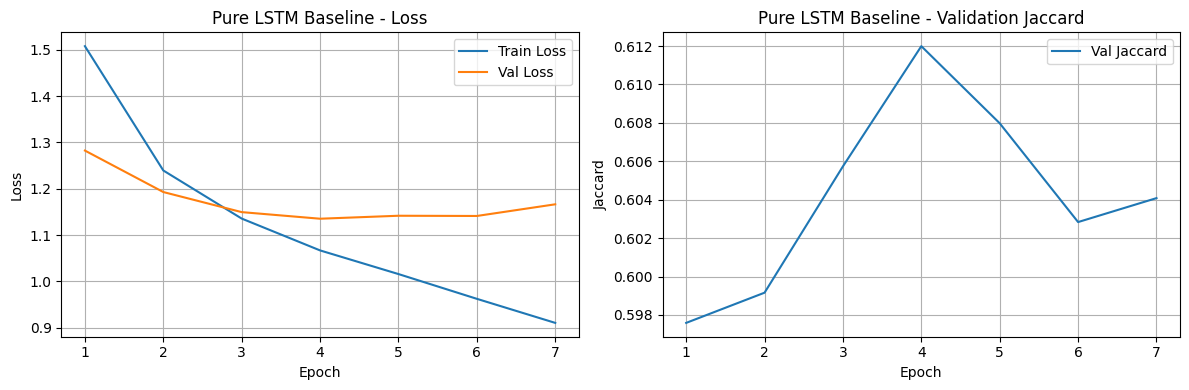

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pure LSTM Baseline - Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history["val_jacc"], label="Val Jaccard")
plt.xlabel("Epoch")
plt.ylabel("Jaccard")
plt.title("Pure LSTM Baseline - Validation Jaccard")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
